In [1]:
from ananke.configurations.collection import HDF5StorageConfiguration
from ananke.visualisation.event import draw_hit_histogram, draw_hit_distribution
from ananke.visualisation.detector import get_detector_scatter3ds
from olympus.configuration.generators import EventGeneratorConfiguration
from olympus.configuration.generators import GenerationConfiguration
from olympus.event_generation.medium import MediumEstimationVariant
from olympus.configuration.generators import UniformSpectrumConfiguration
from ananke.models.collection import Collection
from ananke.schemas.event import EventType
from olympus.configuration.photon_propagation import MockPhotonPropagatorConfiguration

from olympus.configuration.generators import DatasetConfiguration

#from ananke.configurations.presets.detector import single_line_configuration
from olympus.event_generation.generators import generate
from ananke import defaults
from ananke.configurations.detector import DetectorConfiguration
import time
import logging

logging.getLogger().setLevel(logging.INFO)

import cProfile
import pstats

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
/mpcdf/soft/SLE_15/packages/skylake/jax/anaconda_3_2023.03-2023.03-cuda_12.1-12.1.1/0.4.13/lib/python3.10/site-packages/jax/_src/api_util.py:229: SyntaxWarning: Jitted function has invalid argnames {'interactions'} in static_argnames. Function does not take these args.This warning will be replaced by an error after 2022-08-20 at the earliest.
  warnings.warn(f"Jitted function has invalid argnames {invalid_argnames} "


In [2]:
modules_per_line = 20
distance_between_modules = 50.0  # m
dark_noise_rate = 16 *1e-5  # 1/ns
module_radius = 0.21  # m
pmt_efficiency = 0.42  # by Christian S.
pmt_area_radius = 75e-3 / 2.0  # m

detector = DetectorConfiguration.parse_obj(
    {
        "string": {
            "module_number": modules_per_line,
            "module_distance": distance_between_modules,
        },
        "pmt": {
            "efficiency": pmt_efficiency,
            "noise_rate": dark_noise_rate,
            "area": pmt_area_radius,
        },
        "module": {"radius": module_radius},
        "geometry": {
            "type": "single",
        },
        "geometry":{
            "type":"hexagonal",
            "number_of_strings_per_side":3,
            "distance_between_strings":80
            
        },
        "seed": defaults.seed,
    }
)
print(detector)

geometry=SidedGeometryConfiguration(start_position=Position(x=0.0, y=0.0), type=<DetectorGeometries.HEXAGONAL: 'hexagonal'>, number_of_strings_per_side=3, distance_between_strings=80.0) string=StringConfiguration(z_offset=0.0, module_number=20, module_distance=50.0) module=ModuleConfiguration(radius=0.21, module_as_PMT=False) pmt=PMTConfiguration(efficiency=0.42, area=0.0375, noise_rate=0.00016, gamma_scale=0.0) seed=32118


In [1]:
import pandas as pd
path='/u/arego/project/Experimenting/data/AllMerge10.h5'
pd.read_hdf(path,key='hits')

time  string_id  module_id  pmt_id  record_id  type
0     783.488859          1         18       1         19     2
1     783.619152          1         18       3         19     2
2     783.713287          1         18       5         19     2
3     783.694854          1         18      15         19     2
4     384.814463          1         19       1         19     2
...          ...        ...        ...     ...        ...   ...
4436  481.093233         13         17      10         25    20
4437  977.661511         13         18       3         25    20
4438  103.496764         13         18      11         25    20
4439  799.359038         13         19       0         25    20
4440  692.272894         13         19      14         25    20

[2922020 rows x 6 columns]

In [3]:
detector_configuration = detector


# This is optional
photon_propagator_configuration = MockPhotonPropagatorConfiguration(
    resolution=18000,
    medium=MediumEstimationVariant.PONE_OPTIMISTIC,
    max_memory_usage=int(2_147_483_648 / 4) # Great to overcome memory issues
)
photon_propagator_configuration.seed=1

In [4]:
cascade_generation_configuration = GenerationConfiguration(
    generator=EventGeneratorConfiguration(
        seed=9,
        type=EventType.CASCADE,
        spectrum=UniformSpectrumConfiguration(
            log_minimal_energy=2,
            log_maximal_energy=5.5
        ),
        source_propagator=photon_propagator_configuration
    ),
    append=False,
    number_of_samples=15
)

track_generation_configuration = GenerationConfiguration(
    generator=EventGeneratorConfiguration(
        seed=9,
        type=EventType.REALISTIC_TRACK,
        spectrum=UniformSpectrumConfiguration(
            log_minimal_energy=2,
            log_maximal_energy=5.5
        ),
        source_propagator=photon_propagator_configuration
    ),
    append=True, # Important as otherwise no extra records are generated
    number_of_samples=15
)

starting_track_generation_configuration = GenerationConfiguration(
    generator=EventGeneratorConfiguration(
        seed=9,
        type=EventType.STARTING_TRACK,
        spectrum=UniformSpectrumConfiguration(
            log_minimal_energy=2,
            log_maximal_energy=5.5
        ),
        source_propagator=photon_propagator_configuration
    ),
    append=False,
    number_of_samples=15
)

In [6]:
with cProfile.Profile() as profile1: 
    storage_configuration = HDF5StorageConfiguration(
            data_path='data/LargeTrack/9_Break/9.h5',
            read_only=False
    )
    detector_configuration.seed=9
    photon_propagator_configuration.seed=9
    configuration = DatasetConfiguration(
        detector=detector_configuration,
        generators=[track_generation_configuration],
        storage=storage_configuration
    )
    print(configuration)
    start_time=time.time()
    
#     #print(data_path)
    collection = generate(configuration)

    end_time=time.time()
    print(' took ',end_time-start_time)

# Save the profiling results to a .prof file
# profile_output_file = 'tracktimings.prof'
# profile.dump_stats(profile_output_file)

# Notify that the profiling data has been saved
#print(f"Profiling data saved to {profile_output_file}")

generator=EventGeneratorConfiguration(seed=9, type=<EventType.REALISTIC_TRACK: 2>, fix_uuids=False, particle_id=11, start_time=0.0, event_propagator=EventPropagatorConfiguration(resolution=0.2), source_propagator=MockPhotonPropagatorConfiguration(type=<PhotonPropagators.Mock: 'mock'>, medium=<MediumEstimationVariant.PONE_OPTIMISTIC: 'pone_optimistic'>, default_wavelength=450, seed=9, resolution=18000, max_memory_usage=536870912), spectrum=UniformSpectrumConfiguration(log_minimal_energy=2.0, log_maximal_energy=5.5)) number_of_samples=15 drop_empty_records=True append=True


INFO:root:Dropping no hit records
INFO:root:Starting to generate 15 RecordType.REALISTIC_TRACK
INFO:root:Starting to generate 15 records
INFO:root:Finished to generating 15 records


[2024-11-14 19:23:34.198] [TableCreation] [warning] Tables are not available and need to be created. They will be written to '/tmp'. This can take some minutes.
[2024-11-14 19:23:59.840] [proposal.integral] [warning] Precision 1e-06 has not been reached after 12 steps the value is 7.13000675731052e-08!
Using now qags! value = 7.103549312051156e-08, abserr = 4.547238658656801e-14, neval = 399, ier = 5


INFO:root:Starting to propagate 15 records
100%|██████████| 15/15 [02:02<00:00,  8.20s/it]
INFO:root:Finished propagating 15 records
INFO:root:Starting to propagate 9 records.
  0%|          | 0/9 [00:00<?, ?it/s]INFO:root:Starting with record 1 of 9 records.
INFO:root:Processed PMT (S: 2, M: 19, P: 3) for Record 0
INFO:root:Processed PMT (S: 2, M: 19, P: 5) for Record 0
INFO:root:Processed PMT (S: 2, M: 19, P: 2) for Record 0
INFO:root:Processed PMT (S: 2, M: 19, P: 1) for Record 0
INFO:root:Processed PMT (S: 2, M: 19, P: 15) for Record 0
INFO:root:Processed PMT (S: 3, M: 18, P: 1) for Record 0
INFO:root:Processed PMT (S: 3, M: 18, P: 9) for Record 0
INFO:root:Processed PMT (S: 3, M: 18, P: 7) for Record 0
INFO:root:Processed PMT (S: 3, M: 18, P: 13) for Record 0
INFO:root:Processed PMT (S: 2, M: 19, P: 13) for Record 0
INFO:root:Processed PMT (S: 3, M: 19, P: 3) for Record 0
INFO:root:Processed PMT (S: 3, M: 18, P: 5) for Record 0
INFO:root:Processed PMT (S: 3, M: 19, P: 15) for Reco

 took  1997.6606705188751


In [11]:
collection.open()
hit=collection.storage.get_record_ids_with_hits()
display(hit.shape)
collection.close()configuration

(10,)

In [ ]:
storage_configuration = HDF5StorageConfiguration(
        data_path='data/test/StartingTrack100.h5',
        read_only=False
)
configuration = DatasetConfiguration(
    detector=detector_configuration,
    generators=[starting_track_generation_configuration],
    storage=storage_configuration
)

start_time=time.time()
#print(data_path)
collection = generate(configuration)

end_time=time.time()
print(' took ',end_time-start_time)

INFO:root:Dropping no hit records
INFO:root:Starting to generate 100 RecordType.STARTING_TRACK
INFO:root:Starting to generate 100 records
INFO:root:Finished to generating 100 records
INFO:root:Starting to propagate 100 records
INFO:root:Starting to propagate 100 records
100%|██████████| 100/100 [10:36<00:00,  6.36s/it]
INFO:root:Finished propagating 100 records
INFO:root:Starting to propagate 100 records
100%|██████████| 100/100 [10:27<00:00,  6.27s/it]
INFO:root:Finished propagating 100 records
INFO:root:Finished propagating 100 records
INFO:root:Starting to propagate 70 records.
  4%|▍         | 3/70 [02:11<48:17, 43.25s/it]INFO:root:Starting with record 4 of 70 records.
INFO:root:Processed PMT (S: 1, M: 0, P: 4) for Record 5
INFO:root:Processed PMT (S: 1, M: 0, P: 8) for Record 5
INFO:root:Processed PMT (S: 1, M: 0, P: 0) for Record 5
INFO:root:Processed PMT (S: 2, M: 0, P: 0) for Record 5
INFO:root:Processed PMT (S: 2, M: 0, P: 4) for Record 5
INFO:root:Processed PMT (S: 2, M: 0, P

In [7]:
storage_configuration = HDF5StorageConfiguration(
        data_path='data/test/Cascade100.h5',
        read_only=False
)
configuration = DatasetConfiguration(
    detector=detector_configuration,
    generators=[cascade_generation_configuration],
    storage=storage_configuration
)

start_time=time.time()
#print(data_path)
collection = generate(configuration)

end_time=time.time()
print(' took ',end_time-start_time)

INFO:root:Dropping no hit records
INFO:root:Dropped 30 records
INFO:root:Starting to generate 30 RecordType.CASCADE
INFO:root:Starting to generate 30 records
INFO:root:Finished to generating 30 records
INFO:root:Starting to propagate 100 records
100%|██████████| 100/100 [00:08<00:00, 11.51it/s]
INFO:root:Finished propagating 100 records
INFO:root:Starting to propagate 15 records.
  0%|          | 0/15 [00:00<?, ?it/s]INFO:root:Starting with record 1 of 15 records.
INFO:root:Processed PMT (S: 2, M: 0, P: 1) for Record 128
INFO:root:Processed PMT (S: 2, M: 1, P: 1) for Record 128
INFO:root:Processed PMT (S: 2, M: 1, P: 5) for Record 128
INFO:root:Processed PMT (S: 2, M: 1, P: 9) for Record 128
INFO:root:Processed PMT (S: 2, M: 1, P: 3) for Record 128
INFO:root:Processed PMT (S: 2, M: 1, P: 13) for Record 128
INFO:root:Processed PMT (S: 2, M: 1, P: 15) for Record 128
INFO:root:Processed PMT (S: 2, M: 2, P: 2) for Record 128
INFO:root:Processed PMT (S: 2, M: 2, P: 1) for Record 128
INFO:ro

 took  564.8798358440399


In [4]:
from olympus.configuration.generators import (
    NoiseGeneratorConfiguration,
    DatasetConfiguration, GenerationConfiguration,
    BioluminescenceGeneratorConfiguration,
)
from ananke.schemas.event import NoiseType

In [ ]:
for i in range(4,6):
    duration=1000*10**i
    configuration = DatasetConfiguration(
        detector=detector,
        generators=[
            GenerationConfiguration(
                generator=BioluminescenceGeneratorConfiguration(
                    type=NoiseType.BIOLUMINESCENCE,
                    start_time=0,
                    duration=duration,
                    julia_data_path='../olympus-notebook/data/biolumi_sims',
                    batch_size= 48
                ),
                number_of_samples=100
            )
        ],
        storage=HDF5StorageConfiguration(
            data_path=f'data/LargeBio/{duration}.h5',
            read_only=False
        )
    )
    a=time.time()
    generate(configuration)
    print('it took: ', time.time()-a)
    break

INFO:root:Dropping no hit records


In [7]:
configuration

DatasetConfiguration(detector=DetectorConfiguration(geometry=SidedGeometryConfiguration(start_position=Position(x=0.0, y=0.0), type=<DetectorGeometries.HEXAGONAL: 'hexagonal'>, number_of_strings_per_side=3, distance_between_strings=80.0), string=StringConfiguration(z_offset=0.0, module_number=20, module_distance=50.0), module=ModuleConfiguration(radius=0.21, module_as_PMT=False), pmt=PMTConfiguration(efficiency=0.42, area=0.0375, noise_rate=0.00016, gamma_scale=0.0), seed=32118), generators=[GenerationConfiguration(generator=BioluminescenceGeneratorConfiguration(seed=9, type=<NoiseType.BIOLUMINESCENCE: 21>, fix_uuids=False, start_time=0.0, duration=2000.0, julia_data_path='../olympus-notebook/data/biolumi_sims', number_of_sources=None, batch_size=48), number_of_samples=10, drop_empty_records=True, append=False)], storage=HDF5StorageConfiguration(type=<StorageTypes.HDF5: 'hdf5'>, read_only=False, batch_size=100, data_path='data/test/10000.h5', complevel=3, complib='lzo', optlevel=6), st

In [ ]:
for i in range(2):
    duration=1000
    noise_generator_config = NoiseGeneratorConfiguration(
        type=NoiseType.ELECTRICAL,
        start_time=0,
        duration=duration,
    )

    dataset_configuration = DatasetConfiguration(
        detector=detector,
        generators=[
            GenerationConfiguration(
                generator=noise_generator_config,
                number_of_samples=100,
                append=True,
            ),
        ],
        storage=HDF5StorageConfiguration(
            data_path=f'data/LargeElectrical/{duration}.h5',
            read_only=False
        )
    )
    a=time.time()
    col=generate(dataset_configuration)
    print('it took: ', time.time()-a)

INFO:root:Dropping no hit records
INFO:root:Starting to generate 100 RecordType.ELECTRICAL
INFO:root:Dropping no hit records
INFO:root:Dropped 0 records
INFO:root:Finished to generate 0 RecordType.ELECTRICAL
INFO:HDF5CollectionStorage:Starting to optimize HDF5.
INFO:HDF5CollectionStorage:Finished to optimize HDF5.
INFO:root:Dropping no hit records
INFO:root:Dropped 0 records
INFO:root:Starting to generate 100 RecordType.ELECTRICAL


it took:  32.021546602249146


1800

In [ ]:
gen_list=[cascade_generation_configuration,
        track_generation_configuration,
        starting_track_generation_configuration]
data_path_list = ['data/example/HexCascade.h5',
                  'data/example/HexTrack.h5',
                 'data/example/HexStartingTrack.h5']



for generator,data_path in zip([gen_list[1]],[data_path_list[1]]):
    
    storage_configuration = HDF5StorageConfiguration(
            data_path=data_path,
            read_only=False
    )
    configuration = DatasetConfiguration(
        detector=detector_configuration,
        generators=[generator],
        storage=storage_configuration
    )
    try:
        os.remove(data_path)
    except OSError:
        pass
    start_time=time.time()
    print(data_path)
    collection = generate(configuration)
    
    end_time=time.time()
    print(data_path,' took ',end_time-start_time)

In [21]:
with collection:
    records = collection.storage.get_records()
    hits = collection.storage.get_hits()
    sources = collection.storage.get_sources()
    detector = collection.storage.get_detector()
    
records.df

location_x  location_y  location_z  orientation_x  orientation_y  \
0  148.723003  -96.485182  443.736516      -0.479763       0.739510   
1 -152.463171  -90.459403  288.042876      -0.490772       0.756479   
2  120.909707  129.648621  250.813873      -0.436487       0.672804   
3   37.690177 -173.226362  275.013752      -0.127574       0.138117   
4  -73.767739 -161.202490  149.682251      -0.671935       0.543213   
5    4.741039  177.215814  886.409440       0.893941      -0.326575   
6   97.019883  148.374743  403.872637       0.899955      -0.328772   
7  176.436613   17.263940  793.714247       0.073929      -0.027008   
8  133.175644  117.013546  289.996453       0.036936      -0.633776   
9  -42.320266 -172.153760   33.419770      -0.523811       0.093147   

   orientation_z  record_id        energy  length  time  type  particle_id  \
0      -0.472178          0    838.859127  3000.0   0.0     2           11   
1       0.432298          2  32101.272279  3000.0   0.0     2           11   
2       0.597339          5  62422.788087  3000.0   0.0     2           11   
3       0.982165          8  21218.160332  3000.0   0.0     2           11   
4      -0.503412         11  48856.596972  3000.0   0.0     2           11   
5       0.306951         12   3512.396214  3000.0   0.0     2           11   
6      -0.286339         14   2351.196204  3000.0   0.0     2           11   
7      -0.996898         15  19371.532512  3000.0   0.0     2           11   
8       0.772635         16    465.847078  3000.0   0.0     2           11   
9       0.846726         17   2440.523371  3000.0   0.0     2           11   

   duration  
0       NaN  
1       NaN  
2       NaN  
3       NaN  
4       NaN  
5       NaN  
6       NaN  
7       NaN  
8       NaN  
9       NaN

In [49]:
records.df.shape

(9, 13)

In [27]:
#dir(records)

In [4]:
os.getcwd()

'/raven/u/arego/project/Experimenting'

In [9]:
import pandas as pd

In [10]:
df_list=[]
key=['detector', 'hits', 'records', 'sources']
#key=key[1:]
for i in key:
    df_list.append(pd.read_hdf("data/example/Grid_Event_Gen.h5",key=i))

In [ ]:
for j,i in enumerate(df_list):
    print(key[j])
    print(i.shape)
    display(i.head(3))

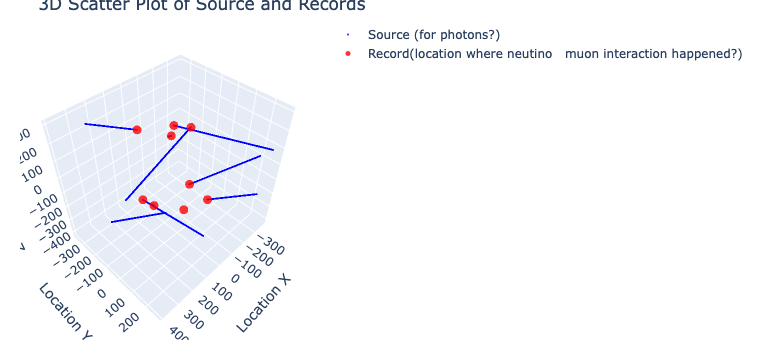

In [21]:
trace1 = go.Scatter3d(
    x=sources['location_x'],
    y=sources['location_y'],
    z=sources['location_z'],
    mode='markers',
    marker=dict(
        size=1,
        color='blue',
        opacity=0.8
    ),
    name='Source (for photons?)'
)

trace2 = go.Scatter3d(
    x=RecordsFromSave['location_x'],
    y=RecordsFromSave['location_y'],
    z=RecordsFromSave['location_z'],
    mode='markers',
    marker=dict(
        size=5,
        color='red',
        opacity=0.8
    ),
    name='Record(location where neutino'
)

# Create the figure and add traces
fig = go.Figure(data=[trace1, trace2])

# Update layout for better visualization
fig.update_layout(
    title='3D Scatter Plot of Source and Records',
    scene=dict(
        xaxis_title='Location X',
        yaxis_title='Location Y',
        zaxis_title='Location Z'
    )
)


fig.update_layout(
    margin=dict(l=20, r=20, t=20, b=20),
    #paper_bgcolor="LightSteelBlue",
)

# Show plot
fig.show()